# Phân tích dữ liệu tuyển dụng dựa trên dữ liệu thu thập được từ LinkedIn

## 1. Chuẩn bị dữ liệu

Tải các thư viện cần thiết chuẩn bị cho bước phân tích và trực quan hóa dữ liệu.

In [1]:
# Thư viện để tạo SparkSession, điểm khởi đầu cho PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, year, month, dayofmonth, when
# Thư viện cung cấp các hàm xử lý dữ liệu cho DataFrame
from pyspark.sql import functions as F

# Thư viện đồ họa thống kê dựa trên matplotlib
import seaborn as sns
# Thư viện vẽ đồ thị và trực quan hóa dữ liệu
import matplotlib.pyplot as plt

# Thư viện để xử lý mảng và tính toán số học
import numpy as np

In [2]:
# Đường dẫn đến trình điều khiển JDBC DuckDB (tệp JAR)
cassandra_db_jdbc = "/home/diin/HocKi_8/BigDATA/Project_Kafka/docker/spark/jars/spark-cassandra-connector-assembly_2.12-3.5.1.jar"
# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Data Analyst with Spark") \
    .config("spark.jars", cassandra_db_jdbc) \
    .config("spark.cassandra.connection.host", "localhost") \
    .config("spark.cassandra.connection.port", "9042") \
    .getOrCreate()
print("Connection created successfully.")

25/04/01 19:00:13 WARN Utils: Your hostname, diin resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlo1)
25/04/01 19:00:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/04/01 19:00:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Connection created successfully.


In [3]:
# Read data from Cassandra
df_cassandra = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="job_data", keyspace="career_opportunity") \
    .load()

# Show the data
df_cassandra.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+
|                  id|             address|        company_name|            job_link|           job_title|posted_time|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+
|ae33bda8-b513-483...|Quận 1, Ho Chi Mi...|            WEALLNET|https://vn.linked...|FRESHER SOFTWARE ...| 2024-11-25|
|e10429aa-0a0b-4ba...|Ho Chi Minh City,...|Relia Software - ...|https://vn.linked...|AI Engineer (Data...| 2025-03-20|
|3cbd9cde-4cab-4fb...|Ho Chi Minh City,...| GiaoHangNhanh (GHN)|https://vn.linked...|        Data Analyst| 2025-03-11|
|d8c83b4f-934d-4f5...|Quận 12, Ho Chi M...|             Lixibox|https://vn.linked...|       Data Engineer| 2025-03-23|
|69d9fa86-2157-4b4...|Ho Chi Minh City,...|     Trusting Social|https://vn.linked...|Backend Engineer ...| 2025-03-18|
|2afa186a-8cf3-4da...|Quận 1, Ho Chi Mi...|     

# 2. Làm sạch và chuẩn hóa bộ dữ liệu

In [4]:
#Kiểm tra các dữ liệu NULL
check_null_data = df_cassandra.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_cassandra.columns])
check_null_data.show()

+---+-------+------------+--------+---------+-----------+
| id|address|company_name|job_link|job_title|posted_time|
+---+-------+------------+--------+---------+-----------+
|  0|      0|           0|       2|        0|       2535|
+---+-------+------------+--------+---------+-----------+



In [5]:
#Kiểm tra các dữ liệu trùng lặp
check_duplicate_data = df_cassandra.groupBy("company_name","job_link","job_title","posted_time").count().filter(col("count") > 1)
check_duplicate_data.show()

+--------------------+--------+--------------------+-----------+-----+
|        company_name|job_link|           job_title|posted_time|count|
+--------------------+--------+--------------------+-----------+-----+
|CÔNG TY TNHH FUTU...|    NULL|Fresher/ Junior-L...|       NULL|    2|
+--------------------+--------+--------------------+-----------+-----+



In [6]:
#Loại bỏ các dữ liệu NULL, trùng lặp
df_cleaned = df_cassandra.dropna().dropDuplicates(["company_name","job_link","job_title","posted_time"])


In [7]:
#Kiểm tra số lượng dữ liệu còn lại sau khi làm sạch
df_cleaned.count()

28817

In [8]:
#Tách cột thời gian đăng tuyển thành các đợn vị thời gian và loại bỏ các cột không cần thiết
job_df_final = df_cleaned.withColumn("posted_year", year(col("posted_time"))) \
                                    .withColumn("posted_month", month(col("posted_time"))) \
                                    .withColumn("posted_day", dayofmonth(col("posted_time"))) \
                                    .drop("posted_time","job_link","address")


In [9]:
# Kiểm tra lại bộ dữ liệu
job_df_final.printSchema()

root
 |-- id: string (nullable = false)
 |-- company_name: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- posted_year: integer (nullable = true)
 |-- posted_month: integer (nullable = true)
 |-- posted_day: integer (nullable = true)



# 3. Xử lý chi tiết bộ dữ liệu nghiên cứu

In [10]:
## Thông tin chi tiết bộ dữ liệu
print('=== THÔNG TIN BỘ DỮ LIỆU ===')
print('Số lượng phần tử trong bộ dữ liệu:', job_df_final.count())
print('Kích thước bộ dữ liệu số cột:',len(job_df_final.columns))

=== THÔNG TIN BỘ DỮ LIỆU ===


Số lượng phần tử trong bộ dữ liệu: 28817
Kích thước bộ dữ liệu số cột: 6


## 3.1 Các công ty (company_name)

In [11]:
# Thông tin của cột company_name
job_df_final.describe("company_name").show()

+-------+------------+
|summary|company_name|
+-------+------------+
|  count|       28817|
|   mean|        NULL|
| stddev|        NULL|
|    min|      Abbott|
|    max|   unilegion|
+-------+------------+



In [ ]:
count_company = job_df_final.count().distinct("company_name")
print('Số lượng công ty trong bộ dữ liệu:', count_company)

Số lượng công ty trong bộ dữ liệu: 54


In [ ]:
# Đếm số lần xuất hiện của từng công ty
conpany_counts = job_df_final.groupBy("company_name").count()
# Hiển thị kết quả
conpany_counts.show()

+--------------------+-----+
|        company_name|count|
+--------------------+-----+
|             Lixibox|  450|
|         Galaxy FinX| 1126|
|            Upskills|  450|
|            Unilever|   50|
|   Highlands Coffee®|  450|
|               BigIn|  451|
|            Portcast|  450|
|              KNOREX|  450|
|Samsung Electroni...|  450|
| GiaoHangNhanh (GHN)|  450|
|Trusting Social C...|  844|
|Samsung Electroni...|  450|
|Orient Software D...|  450|
|  LOTTE Mart Vietnam|  915|
|               TymeX|  549|
| Renesas Electronics|  450|
|   InApps Technology|   42|
|          PUMA Group|  607|
|              Kegmil|  451|
|Global Fashion Group|  450|
+--------------------+-----+
only showing top 20 rows



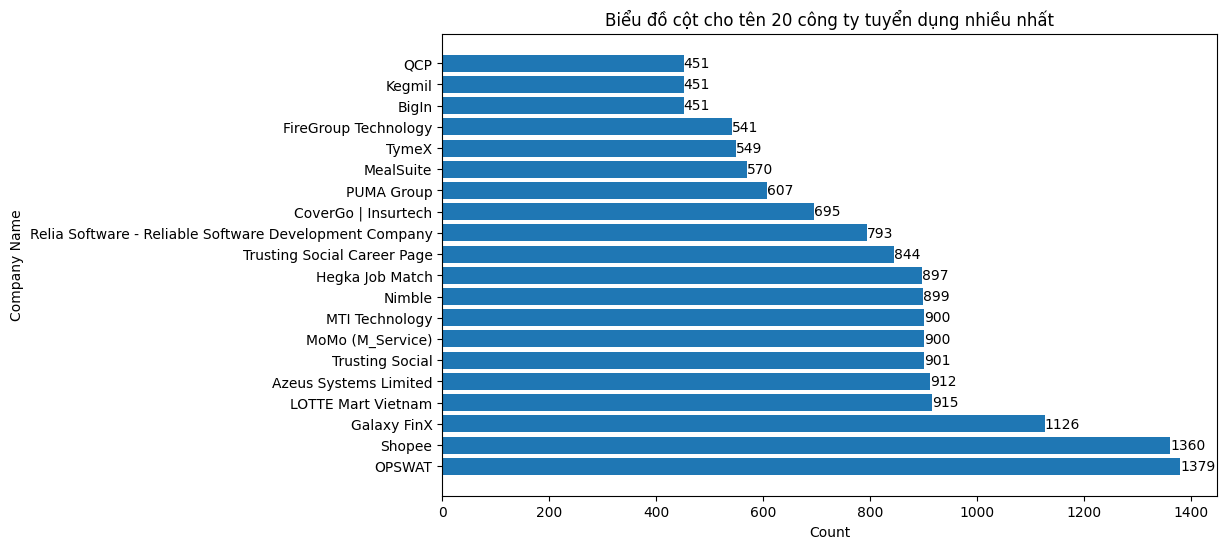

In [13]:
data_company_name = conpany_counts.collect()

# Trích xuất dữ liệu vào danh sách để vẽ đồ thị
top_20_companies = sorted(data_company_name, key=lambda x: x['count'], reverse=True)[:20]

# Trích xuất tên công ty và số lượng tuyển dụng
name = [row['company_name'] for row in top_20_companies]
counts = [row['count'] for row in top_20_companies]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.barh(name, counts)

# Thêm nhãn số lượng vào đầu mỗi cột
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), 
             va='center', ha='left', fontsize=10)

plt.xlabel('Count')
plt.ylabel('Company Name')
plt.title('Biểu đồ cột cho tên 20 công ty tuyển dụng nhiều nhất')

# Hiển thị kết quả
plt.show()


Nhận xét về mức độ tuyển dụng
- OPSWAT (1379) và Shopee (1360) có số lượng tin tuyển dụng cao vượt trội so với các công ty khác.
- Galaxy FinX (1126) cũng có số lượng tuyển dụng đáng kể nhưng thấp hơn một chút so với hai công ty trên.
- Các công ty còn lại có số lượng tuyển dụng dao động từ 451 đến 915, cho thấy sự chênh lệch khá rõ ràng giữa nhóm dẫn đầu và nhóm cuối bảng xếp hạng.

Sự chênh lệch giữa các công ty
- Nhóm đứng đầu (OPSWAT, Shopee, Galaxy FinX) có số lượng tuyển dụng cao hơn đáng kể so với nhóm cuối bảng.
- Điều này có thể phản ánh sự phát triển mạnh của các công ty này, đặc biệt là các doanh nghiệp lớn trong lĩnh vực công nghệ và tài chính.
- Một số công ty như QCP, Kegmil, BigIn có số lượng tuyển dụng thấp hơn nhưng vẫn nằm trong top 20, chứng tỏ họ cũng có nhu cầu mở rộng nhân sự đáng kể.

Dự đoán xu hướng
- Xu hướng tuyển dụng có thể tiếp tục tăng đối với các công ty công nghệ lớn.
- Các công ty thương mại điện tử và tài chính số cũng sẽ tiếp tục mở rộng để đáp ứng nhu cầu của thị trường.
- Một số công ty mới có thể gia nhập danh sách này nếu họ mở rộng quy mô hoạt động.

## 3.2 Lĩnh vực của tuyển dụng (job_title)

In [14]:
# Thông tin của cột job_title
job_df_final.describe("job_title").show()

+-------+--------------------+
|summary|           job_title|
+-------+--------------------+
|  count|               28817|
|   mean|                NULL|
| stddev|                NULL|
|    min|AI Developer (Vie...|
|    max|  [HCM] Data Analyst|
+-------+--------------------+



In [ ]:
# Đếm số lần xuất hiện của từng tiêu đề công việc
job_count = job_df_final.groupBy("job_title").count()
# Hiển thị kết quả
job_count.show()

+--------------------+-----+
|           job_title|count|
+--------------------+-----+
|Software Develope...|   13|
|Software Engineer...|  451|
|Associate System ...|  450|
|Junior Software E...|  450|
|Fresher Software ...|  450|
|Software Engineer...|  882|
|Product, Associat...|  201|
| Software Engineer 2|  451|
|    Python Developer|  751|
|Full Stack Develo...|  899|
|Developer cho web...|  450|
|Data Engineer Intern|  447|
|Staff Data Scientist|  450|
|Backend Engineer ...|  901|
|       Data Analysis|  897|
|Sr Data Engineer ...|  450|
|AI Engineer (Data...|  793|
|Internship 2025 -...|  300|
|Data Analyst (Ope...|  202|
|Machine Learning ...|  844|
+--------------------+-----+
only showing top 20 rows



In [25]:
# Xác định lĩnh vực cho từng công việc
df_grouped = job_count.withColumn(
    "Category",
    when(col("job_title").rlike("(?i)AI|Machine Learning"), "AI")
    .when(col("job_title").rlike("(?i)data"), "Data")
    .when(col("job_title").rlike("(?i)software|developer|full stack"), "Software Development")
    .when(col("job_title").rlike("(?i)backend|cloud|devops"), "Backend & Cloud")
    .when(col("job_title").rlike("(?i)database|sql|nosql"), "Database & SQL")
    .when(col("job_title").rlike("(?i)network|system|admin"), "Network & System")
    .when(col("job_title").rlike("(?i)android|ios|mobile"), "Mobile Development")
    .when(col("job_title").rlike("(?i)product|business"), "Business & Product")
    .when(col("job_title").rlike("(?i)intern|fresher|associate"), "Internship & Entry-Level")
    .otherwise("Other")
)

# Tính tổng số lượng tuyển dụng cho từng lĩnh vực
df_result = df_grouped.groupBy("Category").agg(sum("count").alias("Total Count"))

# Hiển thị kết quả
df_result.show()

+--------------------+-----------+
|            Category|Total Count|
+--------------------+-----------+
|Internship & Entr...|       1057|
|                Data|      11024|
|Software Development|       8004|
|      Database & SQL|        269|
|  Business & Product|       1361|
|               Other|        874|
|                  AI|       4877|
|     Backend & Cloud|        901|
|    Network & System|        450|
+--------------------+-----------+



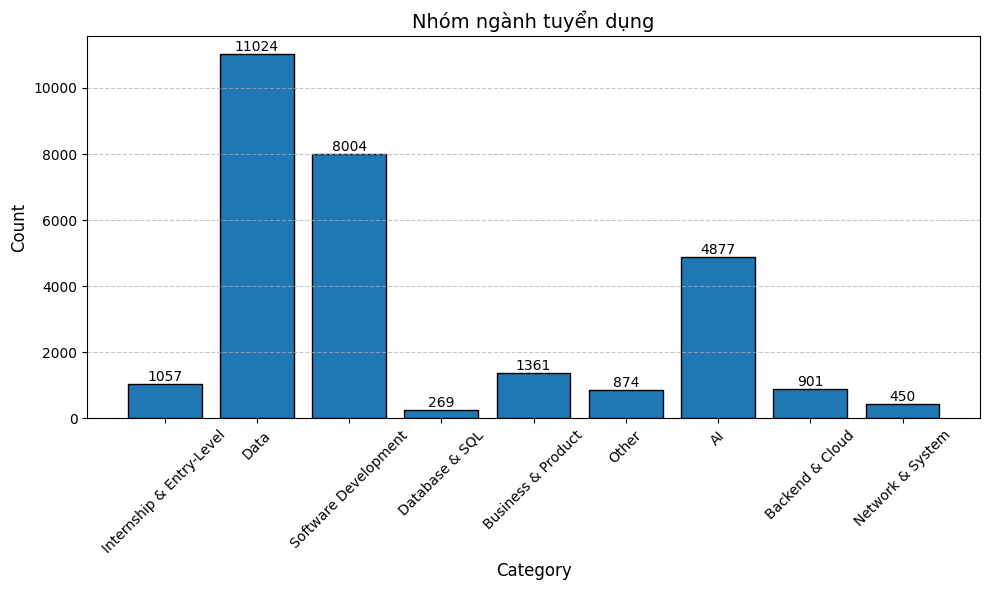

In [ ]:
# Trích xuất dữ liệu vào danh sách để vẽ đồ thị
data_category = df_result.collect()
# Trích xuất tên lĩnh vực và số lượng tuyển dụng
category = [row['Category'] for row in data_category]
counts = [row['Total Count'] for row in data_category]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(category, counts, edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Nhóm ngành tuyển dụng', fontsize=14)
plt.xlabel('Nhóm ngành', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)

# Đặt nhãn trung hoành để hiển thị rõ ràng hơn
plt.xticks(range(len(category)), ha='center',rotation = 45)

# Thêm đường lưới để rõ ràng hơn
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn dữ liệu ở trên mỗi cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Ngành có nhu cầu tuyển dụng cao nhất:
- Data đứng đầu với 11.024 tin tuyển dụng, chứng tỏ nhu cầu rất lớn đối với các vị trí liên quan đến dữ liệu như Data Analyst, Data Engineer, Data Scientist.
- Software Development xếp thứ hai với 8.004 tin tuyển dụng, phản ánh nhu cầu mạnh mẽ đối với lập trình viên phần mềm.

Ngành AI cũng có nhu cầu cao:
- AI đứng thứ ba với 4.877 tin tuyển dụng, cho thấy sự quan tâm ngày càng lớn đối với trí tuệ nhân tạo.

Những nhóm ngành có nhu cầu tuyển dụng thấp hơn:
- Database & SQL (269) và Network & System (450) có số lượng tin tuyển dụng thấp nhất, có thể do nhu cầu thị trường hoặc đặc thù công việc yêu cầu kỹ năng chuyên sâu hơn.
- Internship & Entry-Level (1.057) có lượng tuyển dụng khá thấp, có thể do các công ty yêu cầu kinh nghiệm hoặc ít vị trí cho người mới.

Tổng quan xu hướng tuyển dụng:
- Các lĩnh vực liên quan đến dữ liệu, phần mềm và AI có nhu cầu cao nhất.
- Các nhóm ngành như Database & SQL, Network & System có nhu cầu thấp hơn, có thể do tính đặc thù hoặc tự động hóa đang thay thế một số vị trí

## 3.3 Thời gian đăng bài tuyển dụng (posted_time)

### 3.3.1 Theo tháng (posted_year)

In [31]:
# Đếm số lần xuất hiện của từng tháng
month_counts = job_df_final.groupBy("posted_month").count().orderBy("posted_month")
# Hiển thị kết quả
month_counts.show()

+------------+-----+
|posted_month|count|
+------------+-----+
|           1| 1364|
|           2| 1950|
|           3|23154|
|           7|  450|
|           8|  549|
|          10|   50|
|          11|  400|
|          12|  900|
+------------+-----+



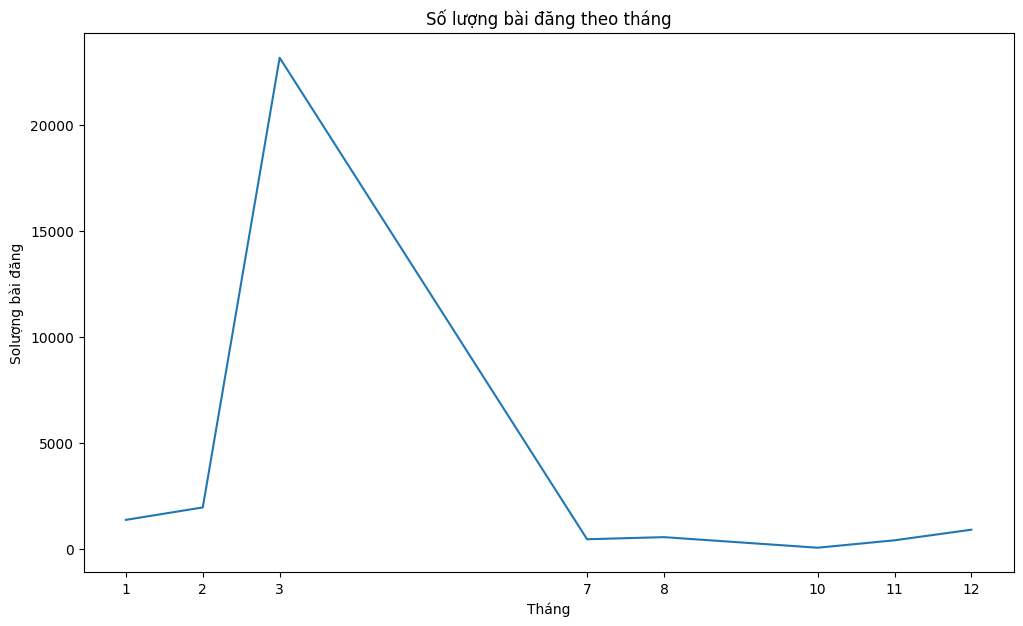

In [ ]:
job_on_month = month_counts.collect()
# Trích xuất dữ liệu vào danh sách để vẽ đồ thị
month = [row["posted_month"] for row in job_on_month]
count = [row["count"] for row in job_on_month]


plt.figure(figsize=(12, 7))
plt.plot(month, count, linestyle='-')

# Thêm nhãn và tiêu đề
plt.xlabel('Tháng')
plt.ylabel('Số lượng bài đăng')
plt.title('Số lượng bài đăng theo tháng')

# Điều chỉnh trục x để đảm bảo văn bản vừa vặn
plt.xticks(month)
plt.show()

Xu hướng chung:
- Số lượng bài đăng tăng mạnh trong khoảng tháng 1 đến tháng 3.
- Đỉnh cao nhất xuất hiện vào tháng 3, với hơn 20.000 bài đăng.
- Sau tháng 3, số lượng bài đăng giảm nhanh chóng và chạm mức thấp nhất từ tháng 7 đến tháng 10.
- Cuối năm (tháng 11, 12) có dấu hiệu tăng nhẹ trở lại.

Điểm nổi bật:
- Tăng đột biến đầu năm: Có thể do các công ty tập trung tuyển dụng vào quý 1 để chuẩn bị cho kế hoạch kinh doanh mới.
- Giảm mạnh sau tháng 3: Có thể do thị trường tuyển dụng bão hòa hoặc các doanh nghiệp đã đủ nhân sự cho năm.
- Thời điểm thấp nhất (tháng 7 - 10): Đây có thể là giai đoạn ít nhu cầu tuyển dụng nhất trong năm.
- Hồi phục nhẹ cuối năm: Các công ty có thể đang chuẩn bị cho chiến dịch tuyển dụng cuối năm hoặc dự án năm sau.

### 3.3.2 Theo ngày (posted_day)

In [38]:
# Đếm số lần xuất hiện của từng ngày
day_counts = job_df_final.groupBy("posted_day").count().orderBy("posted_day")
# Hiển thị kết quả
day_counts.show()

+----------+-----+
|posted_day|count|
+----------+-----+
|         3| 1580|
|         4| 1116|
|         5|  396|
|        10| 2877|
|        11| 1750|
|        12|  648|
|        17| 3400|
|        18| 3031|
|        19| 3149|
|        20| 2446|
|        21|  748|
|        22|  944|
|        23|  518|
|        24| 3262|
|        25| 2211|
|        26|  741|
+----------+-----+



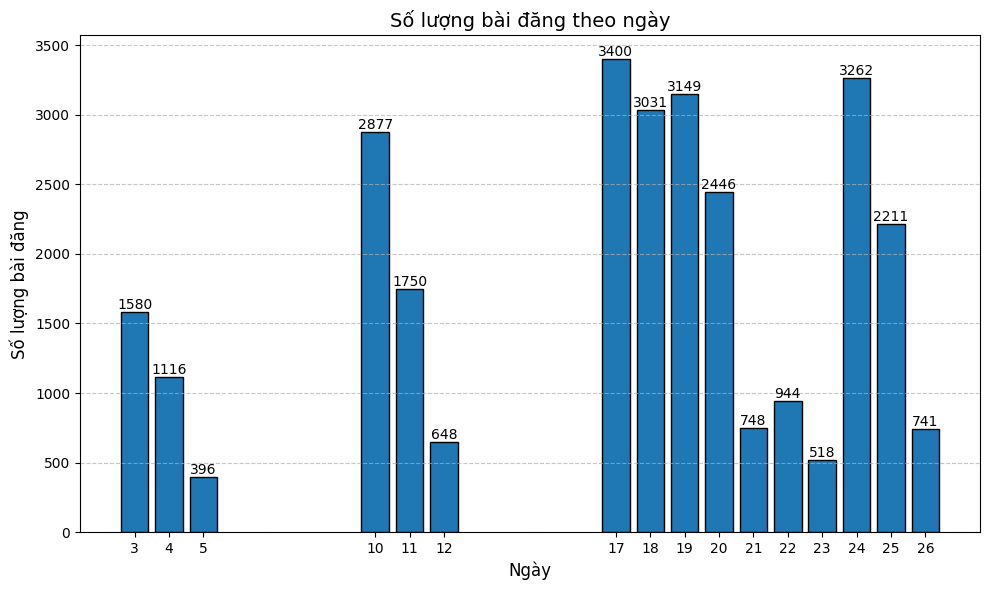

In [39]:
day_counts = day_counts.collect()
# Trích xuất dữ liệu vào danh sách để vẽ đồ thị
day = [row["posted_day"] for row in day_counts]
count = [row["count"] for row in day_counts]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(day, count, edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Số lượng bài đăng theo ngày', fontsize=14)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Số lượng bài đăng', fontsize=12)

# Đặt nhãn trung hoành để hiển thị giá trị ngày
plt.xticks(day, ha='center')

# Thêm đường lưới để rõ ràng hơn
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn dữ liệu ở trên mỗi cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Xu hướng chung:
- Số lượng bài đăng không phân bố đều mà có các đỉnh cao vào một số ngày cụ thể.
- Những ngày có lượng bài đăng cao nhất: ngày 17 (3400 bài), 18 (3031 bài), 25 (3262 bài).
- Một số ngày có lượng bài đăng rất thấp, như ngày 5 (396 bài), 22 (518 bài).

Điểm quan trọng:
- Tăng vọt vào các ngày 10, 17, 18, 19, 25: Đây có thể là các thời điểm có nhiều đợt tuyển dụng hoặc các doanh nghiệp đẩy mạnh đăng tin.
- Giảm đáng kể vào các ngày 5, 22: Có thể do đây là những ngày ít hoạt động tuyển dụng.
- Sự biến động lớn: Số lượng bài đăng không ổn định giữa các ngày, có thể phản ánh các chu kỳ tuyển dụng hoặc các sự kiện đặc biệt.